In [1]:
import wandb

wandb.init()

wandb: Currently logged in as: xhradskyp. Use `wandb login --relogin` to force relogin


In [105]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchvision
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime
from torch.utils.data import random_split
from torchmetrics.functional import dice
import cv2

In [4]:
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

In [5]:
# Define a convolution neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*10*10, 7)

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))      
        output = F.relu(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = F.relu(self.bn4(self.conv4(output)))     
        output = F.relu(self.bn5(self.conv5(output)))     
        output = output.view(-1, 24*10*10)
        output = self.fc1(output)

        return output

In [141]:
def load_data():
    segm_net = torch.load("unet_bce_adam_001_64_1")
    clas_net = torch.load("net_final_cell_crop_4")
    images = np.load("data/images.npy")
    labels = np.load("data/labels.npy")
    
    return segm_net, clas_net, images, labels

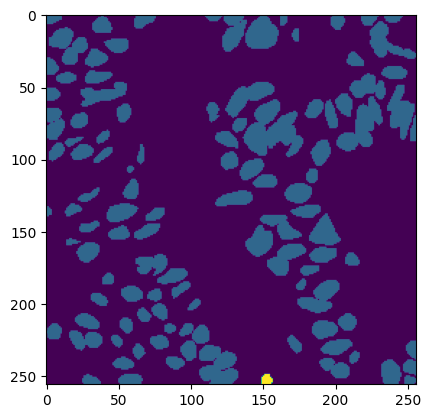

In [142]:
plt.imshow(labels[0][..., 1])

In [154]:
def segmentation(images, labels, n = 0, key = 0.6):
    image = torch.from_numpy(images[n])
    label = torch.from_numpy(labels[n][..., 1].astype(np.uint8))
    image = image.permute(2, 0, 1)
    image = image[None, :]
    label = label[None, :]
    label[label>1] = 1
    
    with torch.no_grad():
        output = segm_net(image.float())
        dice_value = dice(output, label)
        image = image[0].permute(1, 2, 0)
        output = output[0].permute(1, 2, 0)
        label = label[0]
        output[output < key] = 0
        output[output >= key] = 1
        
        # print(dice_value)
        
    return image, output, label

In [144]:
def classification(image, output, label, size=32, image_size=256):
    arr_labels = []
    arr_images = []
    arr_cell_masks = []

    contours, hierarchy= cv2.findContours(output.detach().numpy().astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)

    for i, c in enumerate(sorted_contours): 
        mask = np.zeros(label.shape, dtype=np.uint8)
        cv2.drawContours(mask, [c], -1, (255), cv2.FILLED)
        cropped_cell_mask = cv2.bitwise_and(label.detach().numpy(), label.detach().numpy(), mask=mask)

        x,y,w,h= cv2.boundingRect(c)
        slice_h_1 = y-(size-h)//2
        slice_h_2 = y-(size-h)//2 + size
        slice_w_1 = x-(size-w)//2
        slice_w_2 = x-(size-w)//2 + size

        if(slice_h_1 < 0): 
            slice_h_1, slice_h_2 = (0, size)
        if(slice_w_1 < 0): 
            slice_w_1, slice_w_2 = (0, size)
        if(slice_h_2 > image_size): 
            slice_h_1, slice_h_2 = (image_size-size, image_size)
        if(slice_w_2 > image_size): 
            slice_w_1, slice_w_2 = (image_size-size, image_size)

        cropped_label = label.detach().numpy()[slice_h_1 : slice_h_2, slice_w_1 : slice_w_2]
        cropped_image = image.detach().numpy()[slice_h_1 : slice_h_2, slice_w_1 : slice_w_2]

        arr_labels.append(cropped_label)
        arr_images.append(cropped_image)
        arr_cell_masks.append(cropped_cell_mask)

    arr_images = np.array(arr_images)
    arr_labels = np.array(arr_labels)
    cell_masks = np.array(arr_cell_masks)

    cropped_images = torch.tensor(arr_images)
    cropped_labels = torch.tensor(arr_labels)

    cropped_images = cropped_images.permute(0, 3, 1, 2)
    
    new_label = np.zeros(label.shape, dtype=np.uint8)
    with torch.no_grad():
        for img, lb, mask in zip(cropped_images, cropped_labels, cell_masks):
            img = img[None, :]
            lb = lb[None, :]
            output = clas_net(img.float())
            _, predicted = torch.max(output.data, 1)
            mask[mask==1] = predicted.item()
            new_label = cv2.bitwise_or(new_label, mask)
    
    return new_label

In [147]:
segm_net, clas_net, images, labels = load_data()

tensor(0.9086)


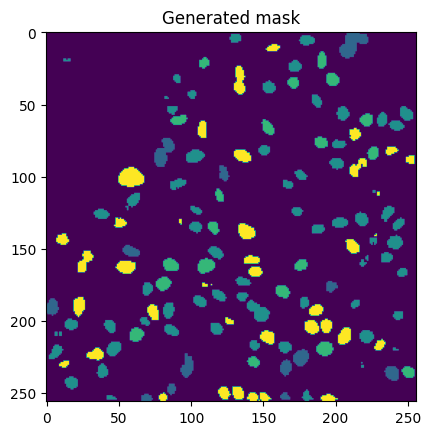

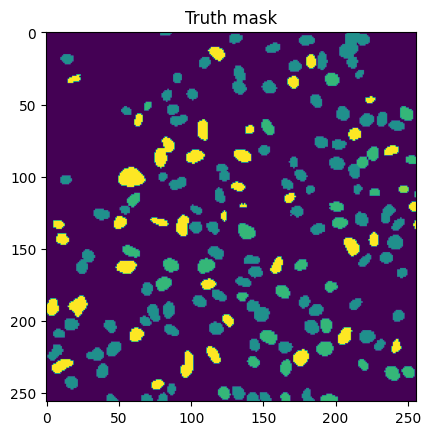

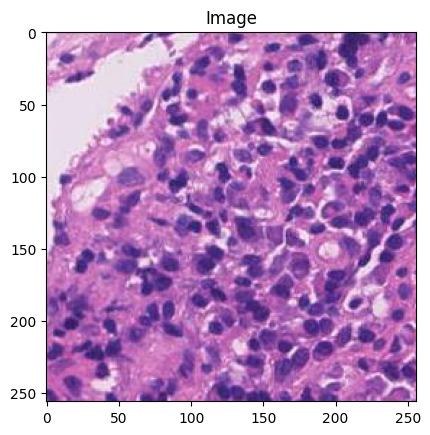

In [155]:
n = 3456

image, output, label = segmentation(images, labels, n=n)
new_label = classification(image, output, label)

print(dice(torch.from_numpy(new_label), torch.from_numpy(labels[n, ..., 1].astype(np.uint8))))

plt.imshow(new_label)
plt.title("Generated mask")
plt.show()
plt.imshow(labels[n, ..., 1])
plt.title("Truth mask")
plt.show()
plt.imshow(images[n])
plt.title("Image")
plt.show()